# 0. [项目流程](https://zhuanlan.zhihu.com/p/27424282) 

## 名词解释 
- Feature 特征变量，也叫自变量，是样本可以观测到的特征，通常是模型的输入。
- Label 标签，也叫目标变量，需要预测的变量，通常是模型的标签或者输出。
- Train Data 训练数据，有标签的数据，由举办方提供。
- Test Data 测试数据，标签未知，是比赛用来评估得分的数据，由举办方提供。
- Train Set 训练集，从Train Data中分割得到的，用于训练模型（常用于交叉验证）。
- Valid Set 验证集，从Train Data中分割得到的，用于验证模型（常用于交叉验证）。

## 问题分析
分析用户过去与当前状态信息，预测用户是否会在领券之后消费。【二分类问题】

- 如何划分数据集？
    - 保持数据线上线下一致性
- 如何构建特征工程
    - 充分利用所有信息，构建组合特征，交叉特征，全面描述样本
- 为什么要用AUC进行评价？
    - 通过rank的方式进行多模型融合
- 潜在的商业价值？
    - 用户忠诚度的探索
    - 促销易感人群探索
    - 商家促销建议探索
    - 促销时间节点探索

## 建模思路
- 业务模式+问题定义+评测设定
- 样本候选集+样本打标签+样本特征
- 训练模型预测+线下效果
- 线上业务+ABtest

[数据科学完整学习路径【附学习资源推荐】](https://www.jianshu.com/p/00dba98eb1d0)

# 1. 数据预览

In [1]:
#基本数据处理包
import pandas as pd
import numpy as np
#时间处理包
from datetime import date, datetime, timedelta
# 画图包
import matplotlib.pyplot as plt

In [61]:
#数据导入
#用户线上点击/消费和优惠券领取表
on_train = pd.read_csv("ccf_online_stage1_train.csv")
#用户线下点击/消费和优惠券领取表
off_train = pd.read_csv("ccf_offline_stage1_train.csv")
#测试数据
off_test = pd.read_csv("ccf_offline_stage1_test_revised.csv")
on_train.head()

,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date
0,13740231,18907,2,100017492,500:50,20160513.0,NaN
1,13740231,34805,1,NaN,NaN,NaN,20160321.0
2,14336199,18907,0,NaN,NaN,NaN,20160618.0
3,14336199,18907,0,NaN,NaN,NaN,20160618.0
4,14336199,18907,0,NaN,NaN,NaN,20160618.0


In [3]:
on_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11429826 entries, 0 to 11429825
Data columns (total 7 columns):
User_id          int64
Merchant_id      int64
Action           int64
Coupon_id        object
Discount_rate    object
Date_received    float64
Date             float64
dtypes: float64(2), int64(3), object(2)
memory usage: 610.4+ MB


In [4]:
off_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754884 entries, 0 to 1754883
Data columns (total 7 columns):
User_id          int64
Merchant_id      int64
Coupon_id        float64
Discount_rate    object
Distance         float64
Date_received    float64
Date             float64
dtypes: float64(4), int64(2), object(1)
memory usage: 93.7+ MB


In [5]:
off_test.info()
#【问题】所有数据的时「时间类型」字段均出现类型错误，后面最好把类型转换成一致，以防数据merge出现大量的空值

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113640 entries, 0 to 113639
Data columns (total 6 columns):
User_id          113640 non-null int64
Merchant_id      113640 non-null int64
Coupon_id        113640 non-null int64
Discount_rate    113640 non-null object
Distance         101576 non-null float64
Date_received    113640 non-null int64
dtypes: float64(1), int64(4), object(1)
memory usage: 5.2+ MB


In [76]:
# 转变数据类型
on_train['Date'] = pd.to_datetime(on_train['Date'],format='%Y%m%d')
on_train['Date_received'] = pd.to_datetime(on_train['Date_received'],format='%Y%m%d')

off_train['Date'] = pd.to_datetime(off_train['Date'],format='%Y%m%d')
off_train['Date_received'] = pd.to_datetime(off_train['Date_received'],format='%Y%m%d')

off_test['Date_received'] = pd.to_datetime(off_test['Date_received'],format='%Y%m%d')
off_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754884 entries, 0 to 1754883
Data columns (total 12 columns):
User_id              int64
Merchant_id          int64
Coupon_id            float64
Discount_rate        object
Distance             float64
Date_received        datetime64[ns]
Date                 datetime64[ns]
Discount_type        float64
Discount_new_rate    float64
Discount_ori         int64
Discount_num         int64
New_Distance         int64
dtypes: datetime64[ns](2), float64(4), int64(5), object(1)
memory usage: 160.7+ MB


## 这里要注意的坑
[python的数据类型返回object 不能进行我们想要的运算操作怎么办](https://blog.csdn.net/super_hong/article/details/93908121?utm_medium=distribute.pc_aggpage_search_result.none-task-blog-2~all~first_rank_v2~rank_v25-1-93908121.nonecase&utm_term=python%20如何把object类型转换)<br>
- object类型的数据转换 转化成str float
- object转化成日期类型 转化成datetime<br>

In [10]:
# 其他字段都比较好理解，除了Discount_rate和Distance，来查看一下
print('Discount_rate 类型：\n',on_train['Discount_rate'].unique())
print('Discount_rate 类型：\n',off_train['Discount_rate'].unique())
print('Discount_rate 类型：\n',off_test['Discount_rate'].unique())

Discount_rate 类型：
 ['500:50' nan '150:50' '50:5' '30:1' '300:50' '300:30' '800:50' '1000:100'
 '10:5' '200:30' '20:10' '200:20' '150:10' '300:10' '150:1' '200:10'
 'fixed' '5:1' '50:10' '100:10' '100:5' '150:20' '200:50' '300:5' '500:10'
 '300:100' '50:30' '50:1' '100:1' '30:20' '10:1' '30:5' '100:50' '150:5'
 '150:30' '300:20' '500:30' '800:100' '50:20' '500:100' '500:20' '1000:20'
 '1000:50' '100:30' '30:10' '200:5' '200:100' '150:100' '200:1' '20:5'
 '1000:10' '20:1' '100:20' '300:1' '500:5' '800:20' '800:30' '1000:300'
 '1000:30' '800:10' '1000:500' '500:300' '1000:5' '800:500']
Discount_rate 类型：
 [nan '150:20' '20:1' '200:20' '30:5' '50:10' '10:5' '100:10' '200:30'
 '20:5' '30:10' '50:5' '150:10' '100:30' '200:50' '100:50' '300:30'
 '50:20' '0.9' '10:1' '30:1' '0.95' '100:5' '5:1' '100:20' '0.8' '50:1'
 '200:10' '300:20' '100:1' '150:30' '300:50' '20:10' '0.85' '0.6' '150:50'
 '0.75' '0.5' '200:5' '0.7' '30:20' '300:10' '0.2' '50:30' '200:100'
 '150:5']
Discount_rate 类型：
 ['30:5' 

## 表1 用户线上点击/消费和优惠券领取行为表字段解释


  - Action: 0-点击；1-购买；2-领取优惠券<br>
  - Coupon_id: null表示无优惠券消费，此时Discount_rate和Date_received字段无意义。“fixed”表示该交易是限时低价活动。<br>
  - Discount_rate: x在\[0,1\]范围内，则表示的是折扣率；x:y表示满x减y；“fixed”表示该交易是限时低价活动。<br>
  注：这个是个很好的指标，店家哪种优惠形式用户使用优惠券购买的更多
  - Date_received：领取优惠券的时间<br>
  - Date：消费时间<br>
  
### 疑惑🤔Action = 0

In [11]:
# 线上有个字段是‘特殊的’， Action = 0 点击， 能否用这个指标来说明该用户是活跃的/对这家店比较感兴趣的
# 首先，我们查看点击的有哪些记录
on_train[on_train.Action == 0]
# 从显示的部分结果，比较有意思的事：618商家大促竟然有没领优惠券就下单了的人(壕)

,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date
2,14336199,18907,0,NaN,NaN,NaT,2016-06-18
3,14336199,18907,0,NaN,NaN,NaT,2016-06-18
4,14336199,18907,0,NaN,NaN,NaT,2016-06-18
5,14336199,18907,0,NaN,NaN,NaT,2016-06-18
6,14336199,18907,0,NaN,NaN,NaT,2016-06-18
...,...,...,...,...,...,...,...
11429819,12985299,10813,0,NaN,NaN,NaT,2016-04-14
11429820,13087731,52509,0,NaN,NaN,NaT,2016-06-09
11429821,13087731,27715,0,NaN,NaN,NaT,2016-06-29
11429822,13087731,52005,0,NaN,NaN,NaT,2016-03-24


In [12]:
# 时间节点618
on_train[(on_train.Action == 0) & (on_train.Date == '2016-06-18')].shape[0]/on_train[on_train.Action == 0].shape[0]

0.009979386882058504

In [13]:
1/365
# 说明后面特征要考虑时间节点的问题

0.0027397260273972603

In [14]:
# 那就大概来看一下「时间」的影响
# 因为我们想要分析的是 「领券之后消费还是没消费，那就分为两类，领券且消费+光领券不消费」
# 我们想要看领券使用与否是否和时间有关系，那当预测时间处于相应的区间，我们也能预测的更准确
# 我们想要的画图数据应该是 Date_received, type(优惠券使用与否)对应的数量
# 图像分布应该是横轴是收到券的时间，y轴是数量，图的类型试试堆积图这样也能知道领券的总量变化情况
%matplotlib inline

- 下次可以试试pd.notnull(字段)

In [15]:
# 先试试线下的数据off_train
temp = off_train.copy()
temp = temp[~(temp.Date_received.isnull())] #排除没有领优惠券的人
temp['type'] = '领券且消费'
temp.loc[temp.Date.isnull(),'type'] = '领券没消费'
temp

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,type
1,1439408,4663,11002.0,150:20,1.0,2016-05-28,NaT,领券没消费
2,1439408,2632,8591.0,20:1,0.0,2016-02-17,NaT,领券没消费
3,1439408,2632,1078.0,20:1,0.0,2016-03-19,NaT,领券没消费
4,1439408,2632,8591.0,20:1,0.0,2016-06-13,NaT,领券没消费
6,1439408,2632,8591.0,20:1,0.0,2016-05-16,2016-06-13,领券且消费
...,...,...,...,...,...,...,...,...
1754877,212662,3021,3739.0,30:1,6.0,2016-05-04,2016-05-08,领券且消费
1754878,212662,2934,5686.0,30:5,2.0,2016-03-21,2016-03-22,领券且消费
1754880,212662,3021,3739.0,30:1,6.0,2016-05-08,2016-06-02,领券且消费
1754882,752472,7113,1633.0,50:10,6.0,2016-06-13,NaT,领券没消费


## 关于.copy
这里有个坑 [pandas 解决 A value is trying to be set on a copy of a slice from a DataFrame的问题](https://blog.csdn.net/zaishijizhidian/article/details/98207892)<br>
如果按照我之前那么些，会有warning，虽然也会出结果

In [16]:
temp1 = off_train[~(off_train.Date_received.isnull())] #排除没有领优惠券的人
temp1['type'] = '领券且消费'
temp1[temp1.Date.isnull()].loc[:,'type'] = '领券没消费'
temp1

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,type
1,1439408,4663,11002.0,150:20,1.0,2016-05-28,NaT,领券且消费
2,1439408,2632,8591.0,20:1,0.0,2016-02-17,NaT,领券且消费
3,1439408,2632,1078.0,20:1,0.0,2016-03-19,NaT,领券且消费
4,1439408,2632,8591.0,20:1,0.0,2016-06-13,NaT,领券且消费
6,1439408,2632,8591.0,20:1,0.0,2016-05-16,2016-06-13,领券且消费
...,...,...,...,...,...,...,...,...
1754877,212662,3021,3739.0,30:1,6.0,2016-05-04,2016-05-08,领券且消费
1754878,212662,2934,5686.0,30:5,2.0,2016-03-21,2016-03-22,领券且消费
1754880,212662,3021,3739.0,30:1,6.0,2016-05-08,2016-06-02,领券且消费
1754882,752472,7113,1633.0,50:10,6.0,2016-06-13,NaT,领券且消费


In [112]:
temp2 = temp.pivot_table(index = 'Date_received',columns='type',values = 'User_id',aggfunc = 'count')

In [124]:
# 解决画图 中文字段出现小框框
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [113]:
temp2.head()

type,领券且消费,领券没消费
Date_received,,
2016-01-01,74,480
2016-01-02,67,475
2016-01-03,74,462
2016-01-04,98,479
2016-01-05,107,584


# [Python可视化：matplotlib 绘制堆积柱状图绘制](https://www.cnblogs.com/hhh188764/p/13618473.html)

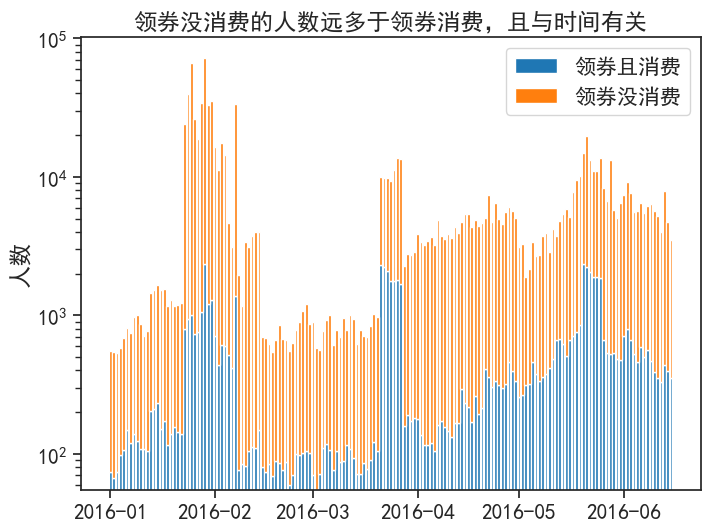

In [130]:
fig, ax = plt.subplots(figsize=(8,6),dpi=100)
ax.bar(x = temp2.index, height = temp2.iloc[:,0],label = '领券且消费')
ax.bar(x = temp2.index, height = temp2.iloc[:,1],bottom = temp2.iloc[:,0],label = '领券没消费')
ax.set_ylabel('人数')
ax.set_title('领券没消费的人数远多于领券消费，且与时间有关')
ax.legend()
plt.yscale('log') #对y进行对数华很重要，压扁ylim，要不就变成了很小的柱形
plt.show()

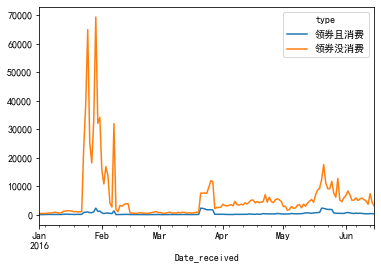

In [78]:
temp2.plot()
# 对比一下

# 小结：领券&时间
整体来看领券的「浪费」很高<br>
尤其是2月份左右的券大部分都是没消费的？？过年？<br>
另外的小高峰则是在3月末4月初？？啥节日？<br>
最后一个小高峰是在5月底6月初,可能是618前夕商家预热狂发优惠券<br>
所以，时间这个因素要考虑到？周末？节假日？<br>
节假日的因素怎么去定义变量？自己整理出节日，然后用哑变量？简单粗暴，分成节假日时间（以节假日为原点，前后一周的时间）和平日？

In [10]:
# 另一个比较奇怪的事情，是否所有点击的用户都下单了？
on_train[(on_train.Action == 0) & (~on_train.Date.isnull())].shape[0]/on_train[on_train.Action == 0].shape[0]
# ok fine. 估计是只放了「点击&下单」的用户，那问题又来了，为啥【Action不等于1？？？？不是购买行为么】

1.0

In [13]:
# 这时候就得去看看【Action=1】是不是理解字段出现了问题，两者搞反了
on_train[on_train.Action == 1]
# 没问题...

,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date
1,13740231,34805,1,NaN,NaN,NaT,2016-03-21
19,10539231,12008,1,NaN,NaN,NaT,2016-06-18
21,10539231,12008,1,NaN,NaN,NaT,2016-06-18
75,15137031,18206,1,NaN,NaN,NaT,2016-05-14
76,15137031,18206,1,NaN,NaN,NaT,2016-05-14
...,...,...,...,...,...,...,...
11429791,12985299,49800,1,100181877,10:5,2016-05-16,2016-05-17
11429810,12985299,49800,1,fixed,fixed,2016-05-17,2016-05-17
11429818,12985299,49800,1,NaN,NaN,NaT,2016-05-20
11429824,13683699,18009,1,NaN,NaN,NaT,2016-03-23


In [14]:
# 这里又发现个有意思的关于‘fixed’，是否限时促销的都会下单
on_train[(on_train.Coupon_id == 'fixed') & (~on_train.Date.isnull())].shape[0]/on_train[on_train.Coupon_id == 'fixed'].shape[0]
# okk..也就是说 其实这个‘fixed‘只要出现一定就会下单？因为否则就没记录？？？
# 看了一下测试集，没有‘fixed’出现，那其实就直接忽略这个类型的优惠

1.0

## 表2 用户线下点击/消费和优惠券领取行为表字段解释
Distance：<br>
用户经常活动的地点离领取优惠券的商家最近门店距离是x\*500米（如果是连锁店，则取最近的一家门店）<br>
x是0～10之间的整数；null表示无此信息，0表示低于500米，10表示大于5公里；

In [301]:
print('Distance 类型：\n',off_train['Distance'].unique())

Distance 类型：
 [ 0.  1. nan  2. 10.  4.  7.  9.  3.  5.  6.  8.]


In [333]:
# 查看数据变化情况
off_train.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,1439408,2632,NaN,NaN,0.0,NaT,2016-02-17
1,1439408,4663,11002.0,150:20,1.0,2016-05-28,NaT
2,1439408,2632,8591.0,20:1,0.0,2016-02-17,NaT
3,1439408,2632,1078.0,20:1,0.0,2016-03-19,NaT
4,1439408,2632,8591.0,20:1,0.0,2016-06-13,NaT


In [312]:
# 这时候发现「时间类」数据出现NaT【时间类缺失值】
off_train.Date.isnull().sum()

977900

In [307]:
# 理解了每个字段的含义之后，要去看一下每张表的情况

# 1. 用户线上点击/消费表
on_train.count() 
#计算非NA值的数量,axis=0 按列计算,axis=1 按行计算,默认axis=0

User_id          11429826
Merchant_id      11429826
Action           11429826
Coupon_id          872357
Discount_rate      872357
Date_received      872357
Date             10773928
dtype: int64

In [313]:
total = on_train.shape[0]
NCNB = sum(on_train.Coupon_id.isnull() & on_train.Date.isnull()) #No coupon no buy :<
CNB = sum(~on_train.Coupon_id.isnull() & on_train.Date.isnull()) #Had coupon but didn't buy it:<
NCB = sum(on_train.Coupon_id.isnull() & ~on_train.Date.isnull())
CB = sum(~on_train.Coupon_id.isnull() & ~on_train.Date.isnull())
    
print('总记录:',total) #总共多少记录
print('没领优惠券没消费：',NCNB) 
print('领了优惠券没消费：',CNB)
print('没领优惠券但消费：',NCB)
print('领了优惠券也消费：',CB)

print('————我是分割线————')
print('大头：没领券的比例',round(NCB/total*100,1),'%') 
print('优惠券使用率',round(CB/872357*100,1),'%')
print('下单率',round(10773928/total*100,1),'%')
print(len(on_train.User_id.unique()),'个用户下过单')
print(len(on_train.Merchant_id.unique()),'个商家')
print(len(on_train.Coupon_id.unique()),'种优惠券')

总记录: 11429826
没领优惠券没消费： 0
领了优惠券没消费： 655898
没领优惠券但消费： 10557469
领了优惠券也消费： 216459
————我是分割线————
大头：没领券的比例 92.4 %
优惠券使用率 24.8 %
下单率 94.3 %
762858 个用户下过单
7999 个商家


## 小结：线上数据集的情况
总共11429826条数据，大部分用户没有领优惠券（92.4%），另外虽然872357个用户领取了优惠券，但是优惠券的使用率低，仅占1/4;<br>
总共10773928条交易数据，762858个用户下过单,回头率高，具体情况各分类如下<br>

- 根据业务情况，可以将用户划分为等级：<br>
   Coupon_id = null & Date = null -> 没领优惠券也没消费 （0人）【没领优惠券的对预测没用，忽略】<br>
   Coupon_id ！= null & Date = null -> 领了优惠券却没有用（655898人）【负样本】<br> 
   Coupon_id = null & Date != null -> 没领优惠券依然消费了「之后可以不发优惠券，降低成本」（10557469人）<br>
   Coupon_id ！= null & Date != null -> 领了优惠券也用了（216459人）【正样本】<br> 
- **【问题1】**同时数据出现不平衡的现象，优惠券使用率仅为25%

In [308]:
#2.用户线下点击/消费表
off_train.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,1439408,2632,NaN,NaN,0.0,NaT,2016-02-17
1,1439408,4663,11002.0,150:20,1.0,2016-05-28,NaT
2,1439408,2632,8591.0,20:1,0.0,2016-02-17,NaT
3,1439408,2632,1078.0,20:1,0.0,2016-03-19,NaT
4,1439408,2632,8591.0,20:1,0.0,2016-06-13,NaT


In [128]:
off_train.count()

User_id          1754884
Merchant_id      1754884
Coupon_id        1053282
Discount_rate    1053282
Distance         1648881
Date_received    1053282
Date              776984
dtype: int64

In [11]:
total = off_train.shape[0]
NCNB = sum(off_train.Coupon_id.isnull() & off_train.Date.isnull()) #No coupon no buy :<
CNB = sum(~off_train.Coupon_id.isnull() & off_train.Date.isnull()) #Had coupon but didn't buy it:<
NCB = sum(off_train.Coupon_id.isnull() & ~off_train.Date.isnull())
CB = sum(~off_train.Coupon_id.isnull() & ~off_train.Date.isnull())
    
print('总记录:',total) #总共多少记录
print('没领优惠券没消费：',NCNB) 
print('领了优惠券没消费：',CNB)
print('没领优惠券但消费：',NCB)
print('领了优惠券也消费：',CB)

print('————我是分割线————')

print('领了优惠券没消费和没领优惠券但消费的比例差不多，分别是',round(CNB/1754884*100,1),'%, ',round(NCB/1754884*100,1),'%') 
print('优惠券使用率',round(CB/1053282*100,1),'%')
print('下单率',round(776984/total*100,1),'%')
print(len(off_train.User_id.unique()),'个用户下过单')
print('平均每个用户下单过',round(total/539438),'次')
print(len(off_train.Merchant_id.unique()),'个商家')
print(len(off_train.Coupon_id.unique()),'种优惠券')

总记录: 1754884
没领优惠券没消费： 0
领了优惠券没消费： 977900
没领优惠券但消费： 701602
领了优惠券也消费： 75382
————我是分割线————
领了优惠券没消费和没领优惠券但消费的比例差不多，分别是 55.7 %,  40.0 %
优惠券使用率 7.2 %
下单率 44.3 %
539438 个用户下过单
平均每个用户下单过 3 次
8415 个商家
9739 种优惠券


## 小结
（1）线下表小结<br>
- 没消费的用户和消费的用户基本平均。<br>
- 总共1754884条数据，「领了优惠券没消费」的人数（977900人）远超过「领了优惠券但消费」的人数（75382人），有着12倍的差距。优惠券的使用比率低，仅为7.2%;<br>
- 既然领了优惠券没消费和没领优惠券但消费的比例差不多，是否可以考虑不发优惠券减少成本，这里就需要精准用户人群，避免无效发放。<br>
- 总共1754884条交易数据，539438个用户下过单,回头率高，具体情况各分类如下<br>

- 根据业务情况，可以将用户划分为等级：<br>
   Coupon_id = null & Date = null -> 没领优惠券也没消费 （0人）<br>
   Coupon_id ！= null & Date = null -> 领了优惠券却没有用（655898人）<br>
   Coupon_id = null & Date != null -> 没领优惠券依然消费了「之后可以不发优惠券，降低成本」（10557469人）<br>
   Coupon_id ！= null & Date != null -> 领了优惠券也用了（216459人）<br>

（2）线上、线下表格对比<br>
对比线上、线下的情况我们可以初步得出：
   - 线上用户主要集中在「没领优惠券但消费」
   - 线下用户主要集中在「领了优惠券没消费」，其次是「没领优惠券但消费」；
   - 商家数量差不多，但是线下用户比线上用户更容易「领了优惠券没消费」，后续需要分析是什么影响了？距离还是优惠力度
 
（3）提出问题<br>
   - 哪类店家的用户优惠券使用率低？优惠金额是多少？
   - 线上线下优惠券的使用是否有差异？差异在哪里？人群还是优惠力度？
   - 用户为什么领了券但没消费？哪些用户喜欢领优惠券？其中哪些消费了
   - 没领优惠券但消费的用户有哪些共同特征？

In [314]:
# 测试数据
off_test.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received
0,4129537,450,9983,30:5,1.0,2016-07-12
1,6949378,1300,3429,30:5,NaN,2016-07-06
2,2166529,7113,6928,200:20,5.0,2016-07-27
3,2166529,7113,1808,100:10,5.0,2016-07-27
4,6172162,7605,6500,30:1,2.0,2016-07-08


In [315]:
off_test.shape[0]

113640

## 三张表小结

In [17]:
# 在线下测试集中出现也在线下训练集中出现的user_id & merchant_id数据
print('线下测试集用户但没出现在线下的训练集中：',set(off_test['User_id']) - set(off_train['User_id']))
print('线下测试集商家但没出现在线下的训练集中：',set(off_test['Merchant_id']) - set(off_train['Merchant_id']))
# 线下训练集和线下测试集数据基本一致

print('---线下的规律找到了，那么线上训练集和线下的测试集关系呢？---')
print('线下测试集的用户出现在线上训练集中的个数：',len(set(off_test['User_id']) & set(on_train['User_id'])))
print('线下测试集的商家出现在线上训练集中的个数：',len(set(off_test['Merchant_id']) & set(on_train['Merchant_id'])))

print('---那么线上训练集和线下的训练集关系呢？---')
print('线下训练集的用户出现在线上训练集中的个数：',len(set(off_train['User_id']) & set(on_train['User_id'])))
print('线下训练集的商家出现在线上训练集中的个数：',len(set(off_train['Merchant_id']) & set(on_train['Merchant_id'])))


线下测试集用户但没出现在线下的训练集中： {2495873, 1286474}
线下测试集商家但没出现在线下的训练集中： {5920}
---线下的规律找到了，那么线上训练集和线下的测试集关系呢？---
线下测试集的用户出现在线上训练集中的个数： 43155
线下测试集的商家出现在线上训练集中的个数： 0
---那么线上训练集和线下的训练集关系呢？---
线下训练集的用户出现在线上训练集中的个数： 267448
线下训练集的商家出现在线上训练集中的个数： 0


## 为什么要使用线上的训练集数据？
最开始，已知「线下训练集」和「线下测试集」，最直观的就是直接两者'划等号'。那为什么提供线上的训练集的数据？<br>
通过以上代码实现，我们可以发现线上训练集和线下测试集出现用户的重合，也就是说我们可以通过线上训练集的数据去提取「测试集」中用户的特征（但是商家没有重合）。起到扩充数据集的作用，可以尝试先仅用「线下训练集」建模预测，再加上「线上训练集」，看看是否有作用。<br>
<br>
另一方面可以这么想，线上数据集可以提取到与用户相关的特征，e.g. 是不是喜欢用优惠券进行购物，如果在线上也是一个喜欢用优惠券的人，那么当线下也推出同等优惠券时，该用户也有可能会去使用。

In [340]:
# .dt.date的目的是为了确保只提取年月日，而不要后面的小时、分钟、秒等信息
# 否则函数的返回结果是“线下训练集的领券时间从 2016-01-01T00:00:00.000000000 到 2016-06-15T00:00:00.000000000”

def from_to(dt,col):
    sub_dt = dt[col].dt.date.unique()
    not_null = sub_dt[sub_dt != 'null']
    return([not_null.min(),not_null.max()])

In [341]:
print('线下训练集的领券时间从',from_to(off_train,'Date_received')[0],'到',from_to(off_train,'Date_received')[1])
print('线下训练集的下单时间从',from_to(off_train,'Date')[0],'到',from_to(off_train,'Date')[1])
print('----莫的感情分割线---')
print('线上训练集的领券时间从',from_to(on_train,'Date_received')[0],'到',from_to(on_train,'Date_received')[1])
print('线上训练集的下单时间从',from_to(on_train,'Date')[0],'到',from_to(on_train,'Date')[1])
print('----莫的感情分割线---')
print('线下测试集的领券时间从',from_to(off_test,'Date_received')[0],'到',from_to(off_test,'Date_received')[1])

线下训练集的领券时间从 2016-01-01 到 2016-06-15
线下训练集的下单时间从 2016-01-01 到 2016-06-30
----莫的感情分割线---
线上训练集的领券时间从 2016-01-01 到 2016-06-15
线上训练集的下单时间从 2016-01-01 到 2016-06-30
----莫的感情分割线---
线下测试集的领券时间从 2016-07-01 到 2016-07-31


时间类型的数据比较容易出bug
[整理总结 python 中时间日期类数据处理与类型转换(含 pandas)](https://www.cnblogs.com/jjliu/p/11603592.html)<br>

整理一下，也就是👇

|type|table_name|start_date|end_date|
|--|--|--|--|
|领券|on_train|2016-01-01|2016-06-15|
| |off_train|2016-01-01|2016-06-15|
| |off_test|2016-07-01|2016-07-31|
|下单|on_train|2016-01-01|2016-06-30|
| |off_train|2016-01-01|2016-06-30|

为保证数据集分布一致，注意到测试集的数据特征是7.1-7.31的领券情况去预测7.15-8.15是否会使用优惠券「也就是周期为：1个月时间领券+领券后的15天内下单看是否会使用」

# 1. 数据集划分 - 滑窗法
## 为什么使用滑窗法？
一般，如果涉及到**严格的时间概念**，e.g. 给出前X天的详细信息，预测未来N天的人流/销售/用户行为等，这时完整的数据为X+N的形式，就可以用**滑窗法**来解决。通过机器学习的方法解决此类问题，**需要构造与问题描述类似的样本格式**。<br>
<br>
O2O这个项目中，我们已知的X是1.1 - 6.30的信息，N=15天的优惠券核销问题 。<br>
我们可以尝试倒着推，测试集的数据为：根据过去的数据A提取特征，已知7.1-7.31之间的领券情况B输入到模型中，预测未来15天的优惠券核销情况C（label未知需预测）。观察训练集数据，发现存在空档 （其中领券的时间为1.1-6.15，下单的时间为1.1-6.30，空出的6.16-6.30是「只有下单的数据」）。因此，要保证数据的分布大致相同，训练集数据「领券情况B」5.15-6.15，「优惠券核销情况C」5.30-6.30，「过去数据A」需要根据测试集的A来决定。接着如果再往前滑动，训练集数据「领券情况B」4.14-5.14，「优惠券核销情况C」4.29-5.29...<br>

这里是预测用户7月领券后15天的情况，通常可能是考虑用过去半年/一年的数据来提取特征，但考虑到这里只有半年的数据，最终决定对半，取3个月，这样我们的【标签预测区间】和【特征提取区间】的数据分别是👇<br>


|数据集|特征提取区间|标签预测区间|
|--|--|--|
|训练集1|1.13-4.13|4.14-5.14|
|训练集2|2.14-5.14|5.15-6.15|
|测试集|3.30-6.30|7.1-7.31|

可以发现1.1-1.12的数据并没有被利用到，考虑到要充分利用数据，因此改为👇<br>

|数据集|特征提取区间(领券+消费)|标签预测区间（领券)|
|--|--|--|
|训练集1|1.1-4.13|4.14-5.14|
|训练集2|2.1-5.14|5.15-6.15|
|测试集|3.15-6.30|7.1-7.31|

（特征是做出某个判断的证据，标签是结论）<br>

测试集给到的时间区间是到0630，但是6.15之后的数据，本身反映不出来客户在15天内会不会用，可能现在没用，但是后面在15天之内用了，测试集在这个区间内的标签没法提取，所以训练集踢出这部分数据。但是在特征提取的时候，一些特征还是可以利用这部分数据的。


## 为什么用过去的数据来提取特征
不管是用户还是商家，其特征并不会有突变，整体来说比较稳定，因此可以用之前一点的数据来反映其本身的特性。


## 为什么滑动取得多分训练集？
- 增加训练样本
- 交叉验证，模型调整参数

- 参考文章👇
    - 时间划窗 https://www.jianshu.com/p/cc485106f809
    - 数据挖掘比赛之“滑窗法” https://zhuanlan.zhihu.com/p/33906481
        
    
## leakage
另外需要指出的是，赛题提供的预测集中，包含了同一个用户在整个7月份里的优惠券领取情况，这实际上是一种leakage，也就是「穿越特征」如果一个用户在1号领过一张优惠券，而且他在8号又重复领了一张，那么这个用户1号领取的那张优惠券很有可能被核销了。**因为如果不使用优惠券，很少有人会领取多次。这就说明未来的信息对于预测现在的情况有很大帮助，在预测区提特征就是想利用这一点。但是这个在实际业务中是无法实现的，因为没人可以穿越到未来。**也就是说，实际业务中，站在7.1这个时间点上，我们是不可能预知未来，他7.8会再领一张。
![Data Leakage](Leakage.png)
<br>

### 什么是Data Leakage？
Data Leakage 基本都是在准备数据的时候，或者数据采样的时候出了问题，误将与结果直接相关或存在颠倒因果关系的feature纳入了数据集。<br>
e.g. 在处理电信用户流失的时候，用原有的数据集轻轻松松就可以把AUC达到0.99以上。这让人非常警惕。于是Chris老师仔细查看了一下模型和数据，原来数据中有一个权重极高的feature是“3个月内的缴费纪录”。很多流失用户的账户内，这个feature的值是0。再进一步，他跟会计核实了一下，在会计记账中，这个feature 代表的是用户已经流失后的三个月的缴费纪录，那肯定就是0了。这是典型的因果关系颠倒。<br>

数据泄露就是说用了不该用的数据，比如<br>
- 在训练模型时，利用了测试集的数据、信息
- 在当前使用了未来的数据
- 在交叉验证进行调参时，使用了验证集的信息参与模型建立


【？？？？？】具体说下第三点，比如对特征进行标准化，正确的方法应该是在训练集上标准化，然后应用到验证集上，而非先标准化，再划分验证集。即：标准化为，(数值-均值)/标准差，这个“均值”和“标准差”应该是训练集的“均值”和“标准差”。“数值”是测试集里的数值。

### 后果
泄漏会导致模型看起来准确，当开始使用模型做出决策，模型则变得非常不准确。 （和「过拟合」的后果是一样的）

## 字段处理 ：折扣率+距离
- Discount_rate因为有多种可能，导致最后的数据类型是‘object’。在这里可以添加一些字段，然后转换成数值类
    - Discount_type : 1（满减类），0（直接打折）,（'fixed'限时促销和'null'无促销，对我们来说是没有用的，都没有使用优惠券）
    - Discount_ori : 满多少
    - Discount_num : 减多少
    - Discount_rate : 打折率， 满减也可以转化成打折率 e.g. 满100减10元就是9折

In [69]:
# 折扣字段处理

def DiscountType(row):
    if ':' in str(row):
        return 1 #满减类
    elif pd.isnull(row):
        return np.nan #直接打折
    else:
        return 0 #包含直接打折和限时折扣

'''
关于转化折扣率，因为对包和函数都不数，最开始想到的是类似excel的find+截取
off_train.Discount_rate.apply(lambda x:str(x).find(':'))
看了大神的，用到了split函数

str.split(str="", num=string.count(str)).
Python split() 通过指定分隔符对字符串进行切片，如果参数 num 有指定值，则分隔 num+1 个子字符串

这里也要避坑，因为我们的Discount_rate不是字符串类型,会告诉你'float' object has no attribute 'split'
'''    


def CovertRate(row):
    if ':' in str(row):
        t = row.split(':')
        return (1 - int(t[1])/int(t[0])) #满减转化
    elif pd.isnull(row) or row == 'fixed':
        return 1.0 #其他都算没打折
    else:
        return float(row) #直接打折
   
    
def Man(row):
    if ':' in str(row):
        t = row.split(':')
        return int(t[0])
    else:
        return 0
    

def Jian(row):
    if ':' in str(row):
        t = row.split(':')
        return int(t[1])
    else:
        return 0      

# 🤔问题 ： distance的缺失值为什么要填充为负数？（好像在哪听过但是忘了

In [70]:
def ProcessData(df):
    df['Discount_type'] = df['Discount_rate'].apply(DiscountType)
    df['Discount_new_rate'] = df['Discount_rate'].apply(CovertRate)
    df['Discount_ori'] = df['Discount_rate'].apply(Man)
    df['Discount_num'] = df['Discount_rate'].apply(Jian)
    return df

off_train = ProcessData(off_train)
off_test = ProcessData(off_test)
on_train  = ProcessData(on_train)

In [71]:
off_train['New_Distance'] = off_train['Distance'].fillna(-1).astype(int)
off_test['New_Distance'] = off_test['Distance'].fillna(-1).astype(int)

In [72]:
# 查看处理后的数据集
off_train.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,Discount_type,Discount_new_rate,Discount_ori,Discount_num,New_Distance
0,1439408,2632,NaN,NaN,0.0,NaN,20160217.0,NaN,1.000000,0,0,0
1,1439408,4663,11002.0,150:20,1.0,20160528.0,NaN,1.0,0.866667,150,20,1
2,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN,1.0,0.950000,20,1,0
3,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN,1.0,0.950000,20,1,0
4,1439408,2632,8591.0,20:1,0.0,20160613.0,NaN,1.0,0.950000,20,1,0


In [73]:
off_train.info()
# 暂时看起来一切正常

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754884 entries, 0 to 1754883
Data columns (total 12 columns):
User_id              int64
Merchant_id          int64
Coupon_id            float64
Discount_rate        object
Distance             float64
Date_received        float64
Date                 float64
Discount_type        float64
Discount_new_rate    float64
Discount_ori         int64
Discount_num         int64
New_Distance         int64
dtypes: float64(6), int64(5), object(1)
memory usage: 160.7+ MB


## 字段处理 ：领券日期
周末/工作日？节日 = 节假日 + 购物节

In [85]:
# 日期是星期几
def Weekday(row):
    if pd.isnull(row):
        return row
    else:
        return date.weekday(row)+1
        #注意从0开始计数的，0-6表示周一到周日

off_train['Weekday'] = off_train.Date_received.apply(Weekday)     
on_train['Weekday'] = on_train.Date_received.apply(Weekday)      
off_test['Weekday'] = off_test.Date_received.apply(Weekday)     
 
off_train['Day_type'] = off_train['Weekday'].apply(lambda x: 1 if x in[6,7] else 0)
on_train['Day_type'] = off_train['Weekday'].apply(lambda x: 1 if x in[6,7] else 0)
off_test['Day_type'] = off_test['Weekday'].apply(lambda x: 1 if x in[6,7] else 0)  


# 🤔两张表直接合并了

In [142]:
# 独热编码，当天是1，其余都是0
weekdaycols = ['weekday_' + str(i) for i in range(1,8)]
tmpdf = pd.get_dummies(off_train['Weekday'])
tmpdf.columns = weekdaycols
off_train[weekdaycols] = tmpdf

tmpdf = pd.get_dummies(off_test['Weekday'])
tmpdf.columns = weekdaycols
off_test[weekdaycols] = tmpdf

tmpdf = pd.get_dummies(on_train['Weekday'])
tmpdf.columns = weekdaycols
on_train[weekdaycols] = tmpdf

# 查看效果
off_train.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,Discount_type,Discount_new_rate,Discount_ori,...,New_Distance,Weekday,Day_type,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7
0,1439408,2632,NaN,NaN,0.0,NaT,2016-02-17,NaN,1.000000,0,...,0,NaT,0,0,0,0,0,0,0,0
1,1439408,4663,11002.0,150:20,1.0,2016-05-28,NaT,1.0,0.866667,150,...,1,6,1,0,0,0,0,0,1,0
2,1439408,2632,8591.0,20:1,0.0,2016-02-17,NaT,1.0,0.950000,20,...,0,3,0,0,0,1,0,0,0,0
3,1439408,2632,1078.0,20:1,0.0,2016-03-19,NaT,1.0,0.950000,20,...,0,6,1,0,0,0,0,0,1,0
4,1439408,2632,8591.0,20:1,0.0,2016-06-13,NaT,1.0,0.950000,20,...,0,1,0,1,0,0,0,0,0,0


# 贴标签
- 15天内领了优惠券且使用 =》 正样本 y = 1
- 15天内领了优惠券没使用 =》 负样本 y = 0
- 压根没领优惠券，不考虑 =》 y = -1

In [153]:
def label(row):
    if pd.isnull(row['Date_received']):
        return -1
    else:
        if row['Date'] - row['Date_received'] <= pd.Timedelta(15,'D'):
            return 1
    return 0   
        
off_train['label'] = off_train.apply(label,axis = 1)
on_train['label'] = on_train.apply(label,axis = 1)

In [154]:
# 查看效果
off_train.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,Discount_type,Discount_new_rate,Discount_ori,...,Weekday,Day_type,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,label
0,1439408,2632,NaN,NaN,0.0,NaT,2016-02-17,NaN,1.000000,0,...,NaT,0,0,0,0,0,0,0,0,-1
1,1439408,4663,11002.0,150:20,1.0,2016-05-28,NaT,1.0,0.866667,150,...,6,1,0,0,0,0,0,1,0,0
2,1439408,2632,8591.0,20:1,0.0,2016-02-17,NaT,1.0,0.950000,20,...,3,0,0,0,1,0,0,0,0,0
3,1439408,2632,1078.0,20:1,0.0,2016-03-19,NaT,1.0,0.950000,20,...,6,1,0,0,0,0,0,1,0,0
4,1439408,2632,8591.0,20:1,0.0,2016-06-13,NaT,1.0,0.950000,20,...,1,0,1,0,0,0,0,0,0,0


# 划分数据集

In [155]:
#训练集一
dataset1=off_train[(off_train.Date_received>='2016-04-14')&(off_train.Date_received<='2016-05-14')]

#用于训练集一提取特征的数据区间
feature1=off_train[((off_train.Date>='2016-01-01')&(off_train.Date<='2016-04-13'))|
                   ((off_train.Date.isnull())&(off_train.Date_received>='2016-01-01')&(off_train.Date_received<='2016-04-13'))]

'''
提取特征这里的条件乍一看可能会想为什么一个限定了null一个没有
其实可以看作：集合A和集合B相交的部分命名为集合C，那A或B = AUB = A + (B-C)
'''


#训练集二
dataset2=off_train[(off_train.Date_received>='2016-05-15')&(off_train.Date_received<='2016-06-15')]

#用于训练集二提取特征的数据区间
feature2=off_train[((off_train.Date>='2016-02-01')&(off_train.Date<='2016-05-14'))|
                   ((off_train.Date.isnull())&(off_train.Date_received>='2016-02-01')&(off_train.Date_received<='2016-05-14'))]


#测试集数据
dataset3 = off_test

#用于测试集提取特征的数据区间(前面是这段时间下单的数据，后面是领券的数据但没消费的)
feature3=off_train[((off_train.Date>='2016-03-15')&(off_train.Date<='2016-06-30'))|
                   ((off_train.Date.isnull())&(off_train.Date_received>='2016-03-15')&(off_train.Date_received<='2016-06-30'))]

In [156]:
# 查看效果
dataset1.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,Discount_type,Discount_new_rate,Discount_ori,...,Weekday,Day_type,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,label
7,1832624,3381,7610.0,200:20,0.0,2016-04-29,NaT,1.0,0.900000,200,...,5,0,0,0,0,0,1,0,0,0
18,163606,1569,5054.0,200:30,10.0,2016-04-21,NaT,1.0,0.850000,200,...,4,0,0,0,0,1,0,0,0,0
43,4061024,3381,7610.0,200:20,10.0,2016-04-26,NaT,1.0,0.900000,200,...,2,0,0,1,0,0,0,0,0,0
52,106443,450,3732.0,30:5,NaN,2016-04-29,NaT,1.0,0.833333,30,...,5,0,0,0,0,0,1,0,0,0
96,114747,1569,5054.0,200:30,9.0,2016-04-26,NaT,1.0,0.850000,200,...,2,0,0,1,0,0,0,0,0,0


# 疑惑🤔关于去重

In [ ]:
#去重

#原始数据收集中，一般会存在重复项，对后面的特征提取会造成干扰。
#这一步原作者并没有做，我也测试了，在同一模型参数下，去除重复可以使最后的结果有所提升。
#这里的drop_duplicates没有指定参数，也就是说只有一行的数据都相同，才会认为是重复
for i in [dataset3,feature3,dataset2,feature2,dataset1,feature1]:
    i.drop_duplicates(inplace=True)
    i.reset_index(drop=True,inplace=True)
    
# 还是不要去重比较好吧，e.g. 双十一这种节点，是可以领取多张满减优惠券叠加使用的，同一时间点某用户在某商家那里领的同类优惠券越多，
# 不越能说明他使用的可能性越大么？要不然领这么多优惠券干啥？

In [ ]:
mm分析
sql
python模型
excel 透视
